# Naive Deep Q-learning

This notebook implements a naive deep Q-learning algorithm in combination with a neural network. The neural network's objective is to approximate the optimal Q-value for each state-action pair in our environment. 

We use a neural network with two linear layers that take a low-level representation of the environment as input and output the Q-values, corresponding to the actions an agent can take from that state. 

SGD will be used as an optimizer with mean square error as a loss function. This naive deep Q-learning algorithm's overall goal is to serve as a benchmark for further improvement, and thus hyperparameter tuning will not be considered in this notebook. Due note, in this naive implementation, we use the same DQN for choosing and evaluate the maximum Q-value. We do not introduce a second network, called the target network, for evaluating the optimal Q-values. 

We test our algorithm on the "CartPole-v0" environment from OpenAI Gym. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center [OpenAI Gym].

References: https://gym.openai.com/envs/CartPole-v0/

## Import Libraries

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

import gym
import random
import numpy as np

from ipynb.fs.full.Plotting import *
import matplotlib.pyplot as plt

In [2]:
random.seed(100)

## Naive Deep Q-network

In [3]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, observation_space, action_space, learning_rate):
        super(LinearDeepQNetwork, self).__init__()
        
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        
        self.fc1 = nn.Linear(*self.observation_space, 128)
        self.fc2 = nn.Linear(128, self.action_space)
        
        self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.loss = nn.MSELoss()
        self.to(self.device)
        
    def forward(self, observation):
        layer1 = F.relu(self.fc1(observation))
        actions = self.fc2(layer1)
        
        return actions  

## Reinforcement Learning Agent

In [4]:
class Agent():
    def __init__(self, observation_space, action_space, learning_rate = 0.001, discount_rate = 0.99, exploration_rate = 1.0,
                 max_exploration_rate = 1, min_exploration_rate = 0.01,  exploration_decay_rate = 0.001):
        
        self.episode = 0
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        
        self.exploration_rate = exploration_rate
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        
        self.policy_network = LinearDeepQNetwork(self.observation_space, self.action_space, self.learning_rate)
        
    def choice_action(self, observation):
        exploration_rate_threshold = np.random.random()
        if exploration_rate_threshold > self.exploration_rate:
            observation = T.tensor(observation, dtype = T.float).to(self.policy_network.device)
            actions = self.policy_network.forward(observation) # Q-values for action in state.
            action = T.argmax(actions).item() # Best Q-value for action in state.
        else:
            action = np.random.choice(self.action_space) # Random action.
            
        return action
    
    def decrease_exploration_rate(self):
        self.exploration_rate = self.min_exploration_rate + \
            (self.max_exploration_rate - self.min_exploration_rate) * np.exp(- self.exploration_decay_rate * self.episode)
        self.episode += 1

    def learn(self, observation, action, reward, next_observation):
        # Set gradient to zero.
        self.policy_network.optimizer.zero_grad()
        
        # Convert to tensors.
        observation = T.tensor(observation, dtype = T.float).to(self.policy_network.device)
        action = T.tensor(action).to(self.policy_network.device)
        reward = T.tensor(reward).to(self.policy_network.device)
        next_observation = T.tensor(next_observation, dtype = T.float).to(self.policy_network.device)
        
        # Calculate loss using Bellman equation.
        q_pred = self.policy_network.forward(observation)[action]
        q_next = self.policy_network.forward(next_observation).max()
        q_target = reward + self.exploration_rate * q_next
        loss = self.policy_network.loss(q_target, q_pred).to(self.policy_network.device)
        
        # Optimizer in action.
        loss.backward()
        self.policy_network.optimizer.step()

## Main Program

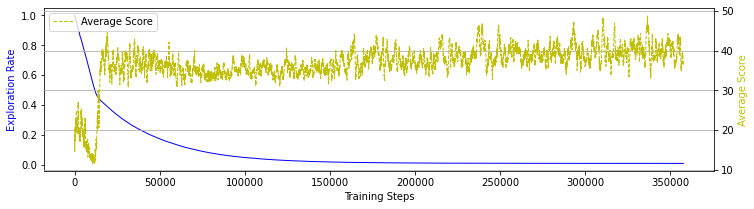

In [5]:
step = 0
episodes = 10000

env = gym.make('CartPole-v1')
agent = Agent(env.observation_space.shape, env.action_space.n)

scores, exploration_rate_history, steps = [], [], []

for i in range(episodes):
    observation = env.reset()
    done = False
    score = 0.0
    
    while not done:
        action = agent.choice_action(observation)
        next_observation, reward, done, info = env.step(action)
        agent.learn(observation, action, reward, next_observation)
        observation = next_observation
        score += reward
        step += 1
        
    scores.append(score)
    steps.append(step)
    exploration_rate_history.append(agent.exploration_rate)
    agent.decrease_exploration_rate()    

plot_learning_curve(steps, scores, exploration_rate_history)